# Computing the power spectrum of the gas field

Example of how to compute a power spectrum from CAMELS data

In [1]:
import numpy as np
import h5py
import MAS_library as MASL
import Pk_library as PKL
import matplotlib.pylab as plt

Get the name of the snapshot

In [2]:
f_snap = '/home/jovyan/Data/Sims/SIMBA/LH_367/snap_020.hdf5'

Open the snapshot file

In [3]:
data = h5py.File(f_snap, 'r')

Read the snapshot header

In [4]:
BoxSize      = data['Header'].attrs[u'BoxSize']/1e3    #size of the snapshot in comoving Mpc/h
redshift     = data['Header'].attrs[u'Redshift']       #reshift of the snapshot
scale_factor = data['Header'].attrs[u'Time']           #scale factor
h            = data['Header'].attrs[u'HubbleParam']    #value of the hubble parameter in 100 km/s/(Mpc/h)
Masses       = data['Header'].attrs[u'MassTable']*1e10 #masses of the particles in Msun/h
Np           = data['Header'].attrs[u'NumPart_Total']  #total number of particles for specie
Omega_m      = data['Header'].attrs[u'Omega0']         #Omega_matter
Omega_L      = data['Header'].attrs[u'OmegaLambda']    #Omega_Lambda

Read the positions and the masses of the gas particles

In [5]:
pos_gas   = data['PartType0/Coordinates'][:]/1e3 #Mpc/h 
mass_gas  = data['PartType0/Masses'][:]*1e10     #Msun/h

Check the masses positions and masses of the gas particles

In [6]:
print('Box size: %.2f Mpc/h'%BoxSize)
print('Snapshot redshift: %.2f'%redshift)
print('%.2f < pos_gas_X < %.2f'%(np.min(pos_gas[:,0]), np.max(pos_gas[:,0])))
print('%.3e < mass_gas  < %.3e'%(np.min(mass_gas), np.max(mass_gas)))

Box size: 25.00 Mpc/h
Snapshot redshift: 0.86
0.00 < pos_gas_X < 25.00
1.219e+07 < mass_gas  < 3.811e+07


Make sure the positions are a numpy float32 array

In [7]:
pos_gas = pos_gas.astype(np.float32)

Define array the will contain the gas density field

In [8]:
grid  = 512
delta = np.zeros((grid,grid,grid), dtype=np.float32) #grid will have (512,512,512) voxels

Assign gas particle positions and masses to the regular grid 
We will use the Cloud-in-Cell mass assignment scheme

In [9]:
MAS     = 'CIC'
verbose = True
MASL.MA(pos_gas, delta, BoxSize, MAS, W=mass_gas, verbose=verbose)


Using CIC mass assignment scheme with weights
Time taken = 1.640 seconds



Check that the mass in the grid is the same as the mass of all particles

In [10]:
print('Sum of all particle masses:         %.3e Msun/h'%np.sum(mass_gas, dtype=np.float64))
print('Sum of the mass in all grid voxels: %.3e Msun/h'%np.sum(delta, dtype=np.float64))

Sum of all particle masses:         2.062e+14 Msun/h
Sum of the mass in all grid voxels: 2.062e+14 Msun/h


calculate the gas overdensity field delta = mass_gas / < mass_gas > - 1

In [11]:
delta /= np.mean(delta, dtype=np.float32)
delta -= 1.0

Check that mean is zero, and minimum cant be smaller than -1

In [12]:
print('%.2f < delta < %.2f'%(np.min(delta), np.max(delta)))
print('< delta > = %.2e'%(np.mean(delta, dtype=np.float64)))

-1.00 < delta < 11278.17
< delta > = -2.41e-06


Calculate the power spectrum

In [13]:
axis     = 0     #specifies the axes along which redshift-space distortions are place. Not used in real-space
MAS      = 'CIC' #specifies the mass assignment scheme used to construct the density field
threads  = 1     #number of openmp threads
verbose  = True
Pk_class = PKL.Pk(delta, BoxSize, axis, MAS, threads, verbose)
k        = Pk_class.k3D
Pk       = Pk_class.Pk[:,0]


Computing power spectrum of the field...
Time to complete loop = 7.31
Time taken = 12.43 seconds


Plot power spectrum

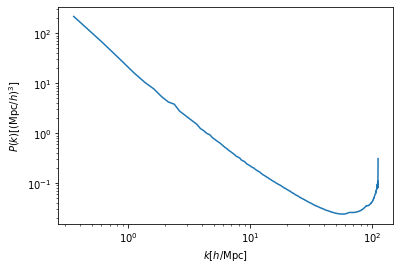

In [14]:
plt.xlabel(r'$k [h/{\rm Mpc}]$')
plt.ylabel(r'$P(k) [({\rm Mpc}/h)^3]$')
plt.xscale('log')
plt.yscale('log')
plt.plot(k, Pk)
plt.show()